# Start Spark Session and Load Data 

In [64]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, max, min

# Start Spark session
spark = SparkSession.builder \
    .appName("Telematics Dashboard") \
    .getOrCreate()

# Load data
df = spark.read.csv(r"C:\allVehicles.csv", header=True, inferSchema=True)

# Data transformation
speed_stats = df.groupBy("tripID").agg(
    avg("gps_speed").alias("avg_speed"),
    max("gps_speed").alias("max_speed"),
    min("gps_speed").alias("min_speed")
)

# Convert to Pandas DataFrame for visualization
pandas_df = speed_stats.toPandas()



# 1. Filtering Data
We can  filter out data for example to focus on trips where the speed exceeded 100 km/h.

In [28]:
from pyspark.sql import SparkSession

# Start a Spark session
spark = SparkSession.builder \
    .appName("High Speed Analysis") \
    .getOrCreate()

# Assuming df is your loaded DataFrame
high_speed_trips = df.filter(df.gps_speed > 100)
high_speed_trips.show()


+------+--------------------+------+--------------------+---------+-------+-----+----+------------------+----+----+------------------+-----+-------+-----+----+------------------+--------+
|   _c0|           timeStamp|tripID|             accData|gps_speed|battery|cTemp| dtc|             eLoad| iat|imap|               kpl|  maf|    rpm|speed|tAdv|              tPos|deviceID|
+------+--------------------+------+--------------------+---------+-------+-----+----+------------------+----+----+------------------+-----+-------+-----+----+------------------+--------+
|  3210| 2017-09-04 17:44:03|     0|07e00718ff38d3e1d...|   101.04| 14.125| NULL|NULL| 38.43137254901961|NULL|NULL|10.387392550143264| 3.49| 1069.0| 12.0|NULL|15.686274509803923|      12|
|  3211| 2017-09-04 17:44:05|     0|081806d0fed0d7e7d...|   118.12| 14.075| NULL|NULL|37.254901960784316|NULL|NULL|  8.91150442477876| 3.39|  837.0| 10.0|NULL|15.686274509803923|      12|
|  3212| 2017-09-04 17:44:06|     0|08200700ff20d4e9d...|   

# 2. Joining Data
Join our telematics data with a simulated maintenance DataFrame, linking by deviceID, and adding imaginary maintenance dates and types.

In [29]:
from pyspark.sql.functions import expr
import random

# Start a Spark session
spark = SparkSession.builder \
    .appName("Maintenance Data Simulation") \
    .getOrCreate()

# Load your main dataset
data_path = r"C:\allVehicles.csv"
df = spark.read.csv(data_path, header=True, inferSchema=True)

# Simulate a maintenance DataFrame by adding artificial maintenance data
maintenance_df = df.select("deviceID").distinct() \
    .withColumn("maintenance_date", expr("current_date()")) \
    .withColumn("maintenance_type", expr("CASE WHEN rand() > 0.5 THEN 'Type A' ELSE 'Type B' END"))

maintenance_df.show()


+--------+----------------+----------------+
|deviceID|maintenance_date|maintenance_type|
+--------+----------------+----------------+
|       1|      2024-04-22|          Type A|
|       4|      2024-04-22|          Type B|
|       2|      2024-04-22|          Type B|
|      12|      2024-04-22|          Type B|
|       5|      2024-04-22|          Type A|
|       8|      2024-04-22|          Type B|
|      11|      2024-04-22|          Type B|
|      13|      2024-04-22|          Type A|
|      16|      2024-04-22|          Type A|
|      19|      2024-04-22|          Type A|
|      15|      2024-04-22|          Type B|
|      22|      2024-04-22|          Type B|
|      20|      2024-04-22|          Type B|
|      23|      2024-04-22|          Type A|
|      34|      2024-04-22|          Type B|
|      28|      2024-04-22|          Type B|
|      37|      2024-04-22|          Type A|
|      35|      2024-04-22|          Type B|
|      24|      2024-04-22|          Type A|
|      36|

In [30]:
# Join the main DataFrame with the simulated maintenance DataFrame
combined_data = df.join(maintenance_df, "deviceID")
combined_data.show()


+--------+---+-------------------+------+--------------------+---------+-------+-----+----+------------------+----+----+---+---+------+-----+----+------------------+----------------+----------------+
|deviceID|_c0|          timeStamp|tripID|             accData|gps_speed|battery|cTemp| dtc|             eLoad| iat|imap|kpl|maf|   rpm|speed|tAdv|              tPos|maintenance_date|maintenance_type|
+--------+---+-------------------+------+--------------------+---------+-------+-----+----+------------------+----+----+---+---+------+-----+----+------------------+----------------+----------------+
|       1|  0|2017-10-31 18:45:59|     0|ffb0fd700220fff43...|      2.2|  14.48| NULL|NULL|44.313725490196084|NULL|NULL|0.0|0.0| 903.0|  4.0|NULL|15.686274509803923|      2024-04-22|          Type A|
|       1|  1|2017-10-31 18:46:00|     0|00b0fda802e804e14...|      3.7|  14.48| NULL|NULL|35.294117647058826|NULL|NULL|0.0|0.0| 938.0|  6.0|NULL|15.294117647058824|      2024-04-22|          Type A|


# 3. Grouping and Aggregating
Find how much the speed varies on trips and how many different trouble codes occur during each trip.

In [65]:
from pyspark.sql.functions import stddev, countDistinct

# Calculate standard deviation of speed and count distinct trouble codes
advanced_stats = df.groupBy("tripID").agg(
    stddev("gps_speed").alias("speed_stddev"),
    countDistinct("dtc").alias("unique_trouble_codes")
)
advanced_stats.show()


+------+------------------+--------------------+
|tripID|      speed_stddev|unique_trouble_codes|
+------+------------------+--------------------+
|   496|14.679026535109964|                   2|
|   463| 8.955583985508024|                   2|
|   471|12.307366962911084|                   2|
|   148|13.054831805273718|                   1|
|   833|  8.30323223999219|                   1|
|   243|13.247425524527628|                   1|
|   392| 10.54426590591198|                   2|
|   540|10.758368362940342|                   2|
|   623|13.103356638265298|                   1|
|   737| 5.766195472871052|                   1|
|   858| 9.914288448819738|                   1|
|  1025| 7.549213572235386|                   1|
|   897|10.829889702048964|                   1|
|    31|11.641979077513557|                   2|
|   516|24.831579529868577|                   2|
|    85| 14.29710472255859|                   2|
|   251|15.698133969887666|                   1|
|   137|11.594826617

# 4. Window Functions
Create a DataFrame that ranks each data point by time within each trip, which can be use for analysing sequences or changes over time.

In [66]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

windowSpec = Window.partitionBy("tripID").orderBy("timestamp")
df_with_row_number = df.withColumn("row_number", row_number().over(windowSpec))
df_with_row_number.show()


+-----+-------------------+------+--------------------+---------+-------+-----+----+-----+----+----+----+----+----+-----+----+----+--------+----------+
|  _c0|          timeStamp|tripID|             accData|gps_speed|battery|cTemp| dtc|eLoad| iat|imap| kpl| maf| rpm|speed|tAdv|tPos|deviceID|row_number|
+-----+-------------------+------+--------------------+---------+-------+-----+----+-----+----+----+----+----+----+-----+----+----+--------+----------+
|22507|2017-08-30 15:31:34|    26|0500fb8803a8fed9c...|     NULL|   NULL| NULL|NULL| NULL|NULL|NULL|NULL|NULL|NULL| 43.8|NULL|NULL|      23|         1|
|22508|2017-08-30 15:31:35|    26|0530fb700408efe0d...|     NULL|   NULL| NULL|NULL| NULL|NULL|NULL|NULL|NULL|NULL| 43.5|NULL|NULL|      23|         2|
|22509|2017-08-30 15:31:36|    26|0528fb48037801d6c...|     NULL|   NULL| NULL|NULL| NULL|NULL|NULL|NULL|NULL|NULL| 43.6|NULL|NULL|      23|         3|
|22510|2017-08-30 15:31:37|    26|0510fb5803b8fbd6c...|     NULL|   NULL| NULL|NULL| NUL

# 5. Pivot Tables
We can generate a pivot table to explore average speed across different throttle positions for each type of dtc.

In [67]:
from pyspark.sql.functions import avg

# Assuming df is already your loaded DataFrame from Spark
pivot_table = df.groupBy("dtc").pivot("tPos").agg(
    avg("gps_speed").alias("avg_speed")
)

# Check the output (optional)
pivot_table.show()


+-----+----+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+--

# Some Visuliation Using Seaborn

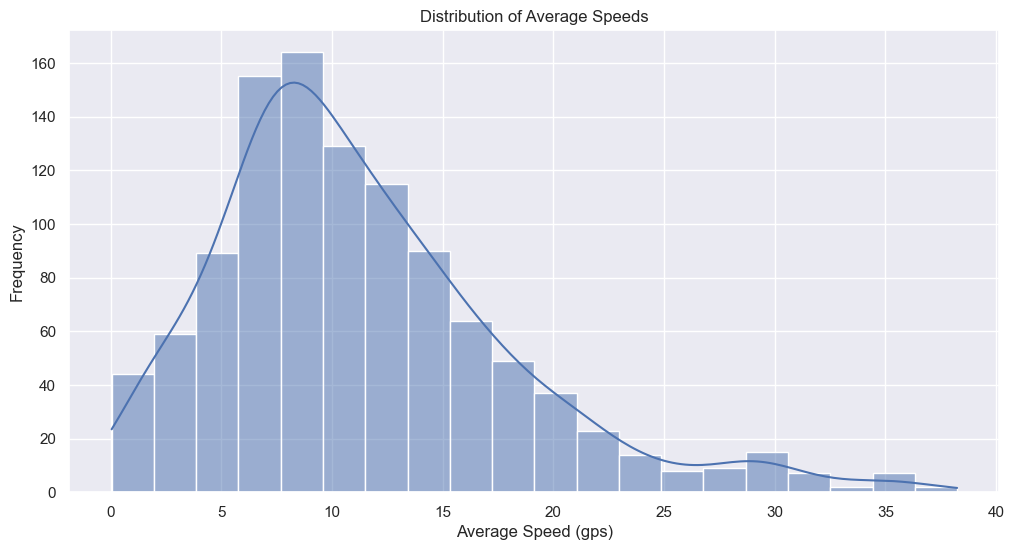

In [68]:
# Create a distribution plot for average speeds
plt.figure(figsize=(12, 6))
dist_plot = sns.histplot(pandas_df['avg_speed'], bins=20, kde=True)
dist_plot.set_title('Distribution of Average Speeds')
dist_plot.set_xlabel('Average Speed (gps)')
dist_plot.set_ylabel('Frequency')
plt.show()


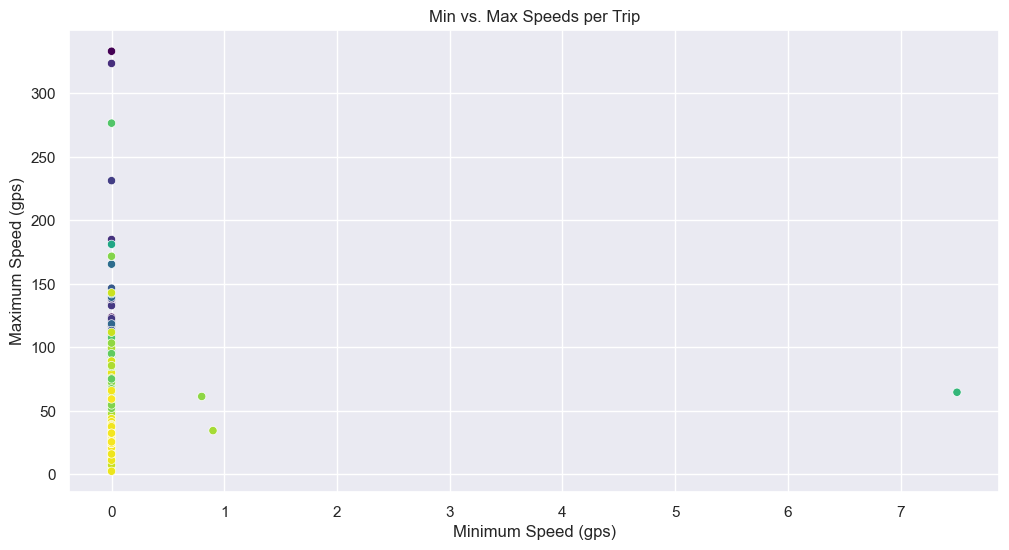

In [69]:
# Create a scatter plot
plt.figure(figsize=(12, 6))
scatter_plot = sns.scatterplot(x='min_speed', y='max_speed', hue='tripID', data=pandas_df, palette='viridis', legend=None)
scatter_plot.set_title('Min vs. Max Speeds per Trip')
scatter_plot.set_xlabel('Minimum Speed (gps)')
scatter_plot.set_ylabel('Maximum Speed (gps)')
plt.show()
